# Unsupervised Methods for Machine Learning

We've covered machine learning methods that are supervised, meaning we have labels in our data and we're training a model to be able to assign those labels.  Now we look at unsupervised methods that can extract meaning from data regardless of the precense of labels.  These methods can be helpful in situations where the data is not labeled but can also provide insight into patterns in labeled data as well.  The first method we'll covered is Principal Components Analysis, a very widespread technique in data science.

Much of the code is borrowed from this notebook: https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.09-Principal-Component-Analysis.ipynb

## Curse of Dimensionality

A lot of techniques for machine learning don't perform as well on data that has a high number of dimensions, or features/columns.  You start to see this once the number of features reaches the hundreds.  The various problems caused by high dimensional data are collectively referred to as *the curse of dimensionality*, and Principal Component Analysis is one of the methods for solving this problem.

PCA is a dimensionality reduction algorithm.  This means that we can apply PCA to our data to end up with less features than we started with.  The PCA algorithm takes the columns in our data set and figures out a way to recombine them in a way that reduces the overall number of columns while retaining as much of the information in the data as possible.

### Why would we want to do this?

As mentioned, a lot of algorithms perform poorly on high dimensional data, so running PCA on the data before feeding it to another algorithm is one way to increase performance, usually in the form of making the other algorithm run faster.  

But there are other reasons to use PCA as well.  A big one is that we can't visualize data in more than three dimensions, and usually visualize data in only two dimensions.  If you want to visualize a higher dimensional data set, say a data set with 10 dimensions (or columns), you can apply PCA to reduce the number of dimensions to 2, and then visualize those 2 dimensions.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_moons

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

from sklearn.metrics import accuracy_score

(-2.7391278364515688,
 2.5801310701596343,
 -0.9477947579593763,
 1.0195904306706842)

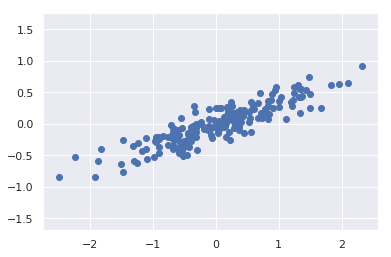

In [3]:
rng = np.random.RandomState(1)
data = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(data[:, 0], data[:, 1])
plt.axis('equal')

Here we have some data, a point cloud in two dimensions.  Is the variance of the data higher in the X axis direction or in the Y axis direction?  Is there a direction other than straight X and straight Y that has a higher variance?  If you were going to redraw the axes anywhere, where would you draw them to maximize the amount of variance on the X axis?

What PCA does is to 'redraw' these axes, the 'components' that PCA returns to us are the vectors along which the variance of our data is maximized.

We imported the PCA algorithm from sklearn, and we can use it like we use all the algorithms from sklearn.  First we initialize the object and then we call the fit method.  

In [4]:
pca = PCA(n_components=2) # we have two columns in our data, so we set the number of components to 2
# however we won't always set the number of components equal to the number of columns, more on this later
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

The first thing we can get from our data is the actual components, the new axes for our data.

In [5]:
pca.components_

array([[-0.94446029, -0.32862557],
       [-0.32862557,  0.94446029]])

The other important thing we can get is the explained variance.

In [6]:
pca.explained_variance_

array([0.7625315, 0.0184779])

This is the amount of the variance in our data explained by the components we just extracted.  The first number is the explained variance with just the first component.  The second number is the increase in explained variance we get by including the second component. 

In [7]:
pca.explained_variance_ratio_

array([0.97634101, 0.02365899])

This is a little more helpful in my opinion, this is the proportion of the variance explained by each component.  So the first component of our data contains 98% of the information present in the data.

(-2.7391278364515688,
 2.5801310701596343,
 -0.9477947579593763,
 1.0195904306706842)

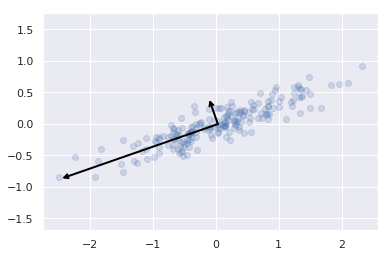

In [8]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    color='black',
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(data[:, 0], data[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal')

Now that we've fit the PCA to our data, we can use the transform method to map our data onto the components we extracted.

Text(0.5, 1.0, 'principal components')

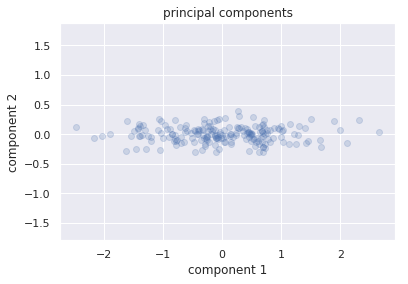

In [9]:
data_pca = pca.transform(data)
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.2)
plt.axis('equal')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('principal components')

Notice we still have the same number of dimensions that we started with.  To actually reduce the dimensions, we  extract the number of dimensions we want and set the components of the remaining dimensions to zero.  In practice, we just set the n_components argument to the number of dimensions we want.  We can reduce our two dimensional data set to one dimension.

In [10]:
pca = PCA(n_components=1)
pca.fit(data)
data_pca = pca.transform(data)
print(data.shape)
print(data_pca.shape)

(200, 2)
(200, 1)


We do an inverse transform here to be able to plot the two point clouds together, but notice that information is lost, we can't truly invert the pca transformation.

(-2.77152878069022, 2.661757596590677, -0.9964674432667129, 1.0219081775900811)

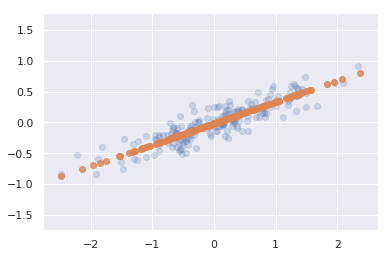

In [11]:
data_inv = pca.inverse_transform(data_pca)
plt.scatter(data[:, 0], data[:, 1], alpha=0.2)
plt.scatter(data_inv[:, 0], data_inv[:, 1], alpha=0.8)
plt.axis('equal')

## PCA in practice

Let's look at an example of the PCA algorithm in practice.  We're going to use a classic data set in ML, the Wisconsin Breast Cancer data set, which is a collection of characteristics of breast cancer cells along with a label of whether the cancer was benign or malignant. 

In [12]:
df = pd.read_csv('wisconsin_breast_cancer.csv')
# The original data set only had these 10 features, so we'll limit ourselves to these
df = df[['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
df.diagnosis = df.diagnosis.map({'M':1, 'B':0})

I want to visualize this data set, but it has 10 dimensions.  We will use PCA to reduce the dimensions to 2 and then visualize it.
 **But first, very important, we must scale the data using standard scaler.**
 
 ## Example 1

In [1]:
# initialize the StandardScaler()
scaler = 
features = df[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
# fit transform the scaler to the features
features = 

# initialize the pca with 2 components
pca = 

# fit transform the features iwth the pca
features = 

# add everything back into a dataframe to work with the following visualization section
df_pca = pd.concat([df[['id', 'diagnosis']], pd.DataFrame(features, columns=['component_1', 'component_2'])], axis=1)
df_pca.head()

SyntaxError: invalid syntax (<ipython-input-1-2989b6e8e216>, line 2)

<Figure size 432x288 with 0 Axes>

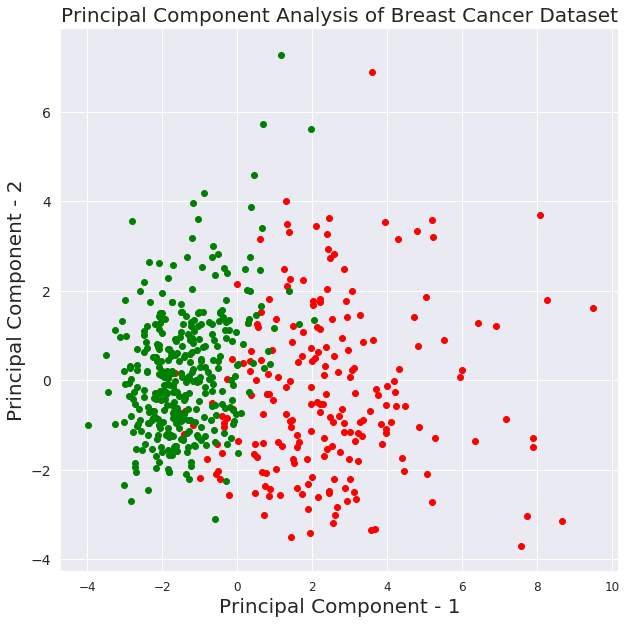

In [15]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Breast Cancer Dataset",fontsize=20)
plt.scatter(df_pca[df_pca.diagnosis == 1].component_1, df_pca[df_pca.diagnosis == 1].component_2,
           color = 'red')
plt.scatter(df_pca[df_pca.diagnosis == 0].component_1, df_pca[df_pca.diagnosis == 0].component_2,
           color = 'green')

We can see that with just two components we can still separate the two different classes in the data set.

## Picking the Number of Components

In the above example, we reduced our data to two components because we were planning to make a 2-dimensional visualization.  If we're using PCA for another purpose, we could reduce our data to 3, 4, or other dimensions as well.  How do we pick a good number of components to extract from our data? 

The basic answer is to look at the variance explained by the components and stop adding components once we reach a point of diminishing returns. 

In [16]:
scaler = StandardScaler()
features = df[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
features = scaler.fit_transform(features)

pca = PCA(n_components = 10)
features = pca.fit_transform(features)
print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_.cumsum()

[5.47858799e-01 2.51871359e-01 8.80615179e-02 4.99009436e-02
 3.72539190e-02 1.24141749e-02 8.00853104e-03 3.48897928e-03
 1.11354606e-03 2.82305888e-05]


array([0.5478588 , 0.79973016, 0.88779168, 0.93769262, 0.97494654,
       0.98736071, 0.99536924, 0.99885822, 0.99997177, 1.        ])

In [ ]:
def plot_pca(x_train_, cols_list):
    
    max_feat = x_train_.shape[1] + 1
    
    cov_mat = np.cov(x_train_.T)
    
    eigen_vals, eigen_vects = np.linalg.eig(cov_mat)
    
    tot = sum(eigen_vals)

    var_exp_ratio = [(i/tot) for i in eigen_vals]

    cum_var_exp_ratio = np.cumsum(var_exp_ratio)
    
    cum_var_exp_ratio = [ratio for ratio in cum_var_exp_ratio]
    cum_var_exp_ratio = [cum_var_exp_ratio[0]] + cum_var_exp_ratio
    
    
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.bar(range(1, max_feat), var_exp_ratio, label='Individual explained variance', alpha=0.5, color='red')
    ax.step(range(1, max_feat+1), cum_var_exp_ratio, label='Cumulative explained variance')
    ax.set_xlabel('PCA index')
    ax.set_ylabel('Explained variance ratio')
    ax.legend(loc='best')
    plt.yticks(np.arange(0, 1.05, 0.05))
    plt.xticks(np.arange(1, max_feat), cols_list, rotation=90)
    plt.grid()
    plt.show()

In [17]:
scaler = StandardScaler()
features = df[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
features = scaler.fit_transform(features)

pca = PCA(n_components = 5)
features = pca.fit_transform(features)
print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_.cumsum()

[0.5478588  0.25187136 0.08806152 0.04990094 0.03725392]


array([0.5478588 , 0.79973016, 0.88779168, 0.93769262, 0.97494654])

So with this data, 3, 4, or 5 would all be reasonable choices for the number of components to keep.

## Clustering

Clustering algorithms highlight patterns in data by grouping together similar instances into clusters.  This can alert you to patterns you might not have seen in the absence of labels.  A classic example of successfully applied clustering is the identification of new types of diabetes.  Traditional studies grouped diabetes into two types, while newer studies have used clustering algorithms on data from patients with diabetes to hypothesize additional types of diabetes. 

Kmeans is the most common type of clustering algorithm.  It requires that you specify the number of clusters that you expect, which is a sticking point when using this algorithm.  It works broadly as follows:
1. Randomly initialize the chosen number of cluster centers.  
2. Assign data points to clusters according to the closest cluster center.
3. Update the cluster centers so that they are in middle (mean) of all data points assigned to their cluster.
4. Repeat steps 2 and 3 until the cluster centers are stable -- not moving much with each iteration.

This is best seen through some gifs animating the algorithm in action, here's one https://dashee87.github.io/images/kmeans.gif and there's a lot of other good ones if you search.

Here's a simple example for getting the basic idea.

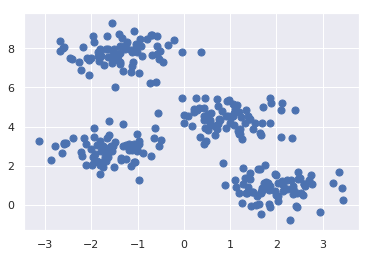

In [41]:
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)

In [42]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

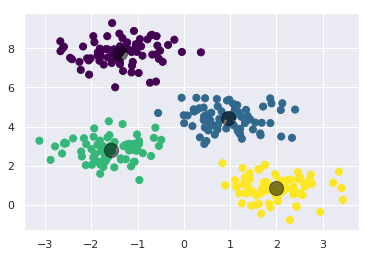

In [43]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

## Problems with KMeans 

### Problem 1: We need to specify the number of clusters

Note that we could visually see the 4 clusters, making it trivial to set the number of clusters to 4.  If we set the number of clusters to numbers other than 4 we get much less good results.

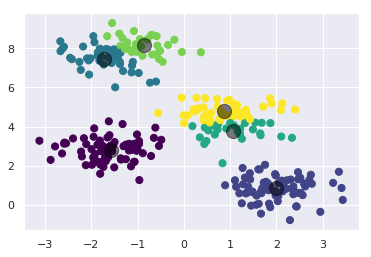

In [44]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

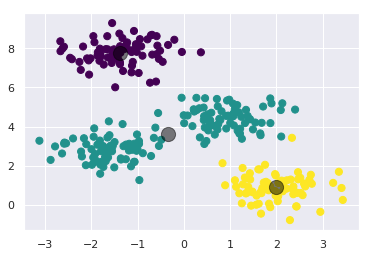

In [46]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

### Solution: Deciding on the number of clusters 

When the number of clusters is less obvious, various techniques exist for choosing a number.  One of the most intuitive is the 'elbow technique.'  This is very similar to what we did with PCA, where we choose the number of components based on when we saw diminishing returns on the explained variance.  We do the same thing here, but instead of explained variance we use the sum of squared distances, which is the total squared distance between each point and it's cluster center.  Note that this always decreases as the number of clusters increases, but we look at a graph to find the point of diminishing returns.  This point is the 'elbow' in the graph, hence the name.  Note that you could generate a similar graph with PCA and find the elbow.

In [47]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(X)
    Sum_of_squared_distances.append(kmeans.inertia_)

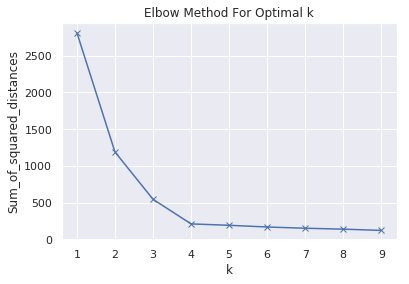

In [48]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow is pretty clearly at 4, though in a real life case it may not be so clear.

### Problem 2: Clusters are Linearly Separable

Another shortcoming of kmeans clustering is that the generated clusters are always linearly separable.  However, sometimes the data has nonlinear boundaries. 

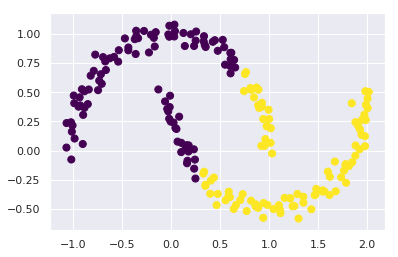

In [49]:
X, y = make_moons(200, noise=.05, random_state=0)


labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')

This may be getting too far in the weeds, but this is a great situation to apply the kernel trick, a wonderful and interesting machine learning technique I encourage you to read about if you're interested.  

### Solution: Sklearn has a model built for this purpose called Spectral Clustering

/home/steve/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


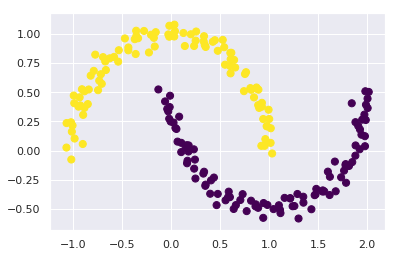

In [51]:
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')

### Clustering on the Breast Cancer Data Set

Let's revisit the breast cancer data set we were working with.

In [52]:
df = pd.read_csv('wisconsin_breast_cancer.csv')
# The original data set only had these 10 features, so we'll limit ourselves to these
df = df[['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
df.diagnosis = df.diagnosis.map({'M':1, 'B':0})

scaler = StandardScaler()
features = df[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
features = scaler.fit_transform(features)

In [53]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(features)
    Sum_of_squared_distances.append(kmeans.inertia_)

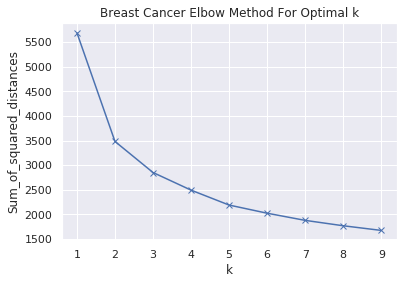

In [55]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Breast Cancer Elbow Method For Optimal k')
plt.show()

Here we can see the optimal clusters are 2, which is what we would expect.

In [68]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(features)
cluster = kmeans.predict(features)
df['cluster_number'] = cluster

In [69]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,cluster_number
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,1
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,1
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,1
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,1


I want to check the accuracy of our clustering compared to the actual diagnosis.  The labels are abitrary, so we're looking for either a high or a very low accuracy.

In [70]:
accuracy_score(df.diagnosis, df.cluster_number)

0.9033391915641477

Let's use PCA both to visualize our generated clusters, and to see how the accuracy compares on a 5 dimension reduction.

In [73]:
scaler = StandardScaler()
features = df[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
features = scaler.fit_transform(features)

pca = PCA(n_components = 2)
features = pca.fit_transform(features)

df_pca = pd.concat([df[['id', 'cluster_number']], 
                    pd.DataFrame(features, columns=['component_1', 'component_2'])], axis=1)
df_pca.head()

,id,cluster_number,component_1,component_2
0,842302,1,5.224155,3.204428
1,842517,1,1.728094,-2.540839
2,84300903,1,3.969757,-0.550075
3,84348301,1,3.596713,6.905070
4,84358402,1,3.151092,-1.358072


<Figure size 432x288 with 0 Axes>

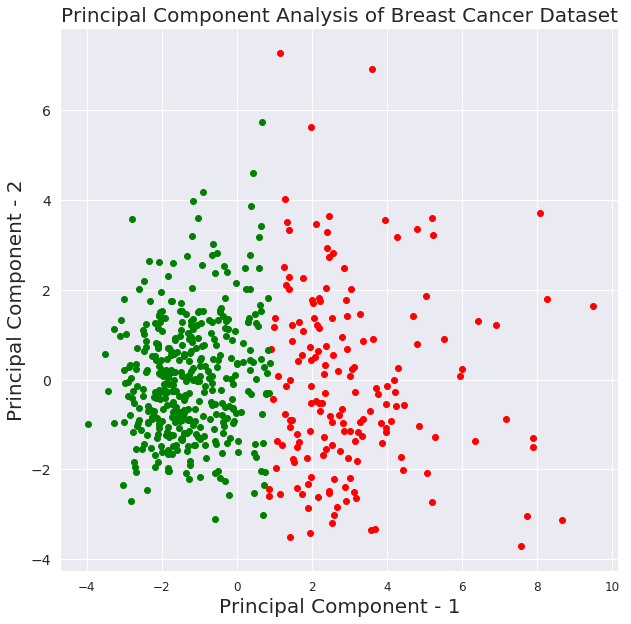

In [75]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Breast Cancer Dataset",fontsize=20)
plt.scatter(df_pca[df_pca.cluster_number == 1].component_1, df_pca[df_pca.cluster_number == 1].component_2,
           color = 'red')
plt.scatter(df_pca[df_pca.cluster_number == 0].component_1, df_pca[df_pca.cluster_number == 0].component_2,
           color = 'green')

Our clusters look very similar to the actual diagnoses from above, the loss in accuracy is coming from the overlaps in the middle in the actual diagnoses.

Let's see if the accuracy is the same on a 5 dimension feature set compared to the full 10 dimension feature set.

In [77]:
# standard scale the features before feeding into PCA
scaler = StandardScaler()
features = df[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
features = scaler.fit_transform(features)

# Use pca with number of components 5 to transform the features
pca = PCA(n_components = 5)
features = pca.fit_transform(features)

# Use kmeans with n_clusters 2 to predict the cluster numbers
kmeans = KMeans(n_clusters = 2)
kmeans.fit(features)
cluster = kmeans.predict(features)
df['cluster_number'] = cluster

accuracy_score(df.diagnosis, df.cluster_number)

0.9033391915641477

### Example 2: PCA and Clustering on the Iris Data Set

In [101]:
iris = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None,
                  names = ["sepal_length","sepal_width","petal_length","petal_width","species"])

<Figure size 432x288 with 0 Axes>

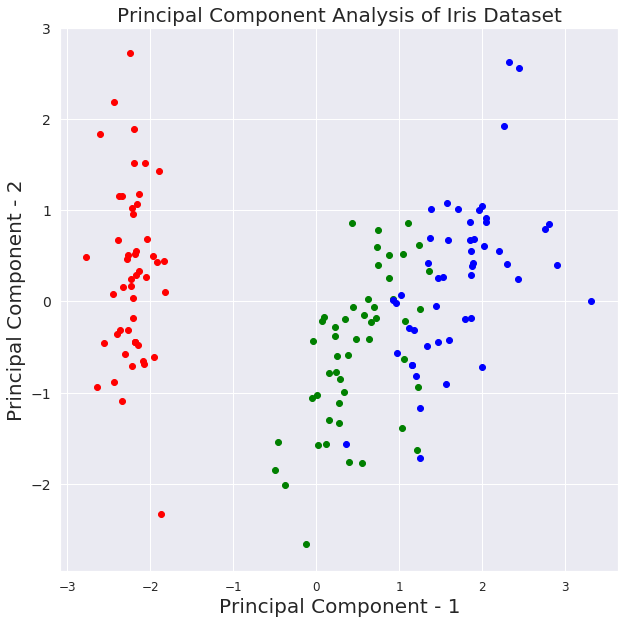

In [105]:
# Use PCA to visualize the data set
iris_features = iris[["sepal_length","sepal_width","petal_length", "petal_width"]]

# scale the features


# initialize the pca, how many components do we need to visualize?


# fit transform the pca to the features


iris_pca = pd.concat([iris.species, iris_features], axis=1)

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Iris Dataset",fontsize=20)
for species_name, color_name in zip(iris.species.unique(), ['red', 'green', 'blue']):
    temp_df = iris_pca[iris_pca.species == species_name]
    plt.scatter(temp_df.component_1, temp_df.component_2,
               color = color_name)

In [87]:
# Use the Elbow Method to find the Optimal K
iris_features = iris[["sepal_length","sepal_width","petal_length"]]

scaler = StandardScaler()
iris_features = scaler.fit_transform(iris_features)

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    # initialize a kmeans with k clusters
    # fit the kmeans to the features
    # append kmeans.intertia to Sum_of_squared_distances

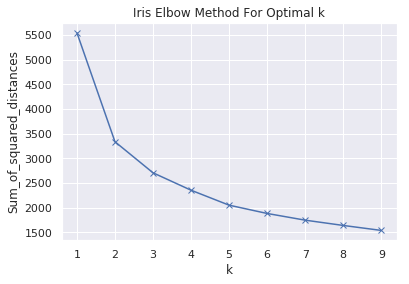

In [88]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Iris Elbow Method For Optimal k')
plt.show()